In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path

repo_root = Path.cwd().parent.parent
sys.path.insert(0, str(repo_root))

from will_replication.my_utils.utils import SIMPLE_MODEL_POOL_CONFIG, TOKENS_PER_MILLION

In [157]:
pool_cfg =SIMPLE_MODEL_POOL_CONFIG

In [158]:
# MODEL_NAME_S="Qwen/Qwen2.5-Math-7B-Instruct"
# MODEL_NAME_L="Qwen/Qwen2.5-Math-7B-Instruct"

MODEL_NAME_S="openai/gpt-oss-20b"
MODEL_NAME_L="openai/gpt-oss-120b"
# MODEL_NAME_L="Qwen/Qwen2.5-Math-7B-Instruct"
MS=MODEL_NAME_S.replace('/', '-')
ML=MODEL_NAME_L.replace('/', '-')

MS_INPUT_COST = pool_cfg[MODEL_NAME_S]["model_costs"]["input_per_mill"] / TOKENS_PER_MILLION
MS_OUTPUT_COST = pool_cfg[MODEL_NAME_S]["model_costs"]["output_per_mill"] / TOKENS_PER_MILLION
ML_INPUT_COST = pool_cfg[MODEL_NAME_L]["model_costs"]["input_per_mill"] / TOKENS_PER_MILLION
ML_OUTPUT_COST = pool_cfg[MODEL_NAME_L]["model_costs"]["output_per_mill"] / TOKENS_PER_MILLION
K_SMALL=1
TEMP_SMALL=1.0
K_LARGE=1
TEMP_LARGE=1.0

SCORE_COL = "calibrated_score"
if K_SMALL == 1:
    SCORE_COL = "score"

PROBING_DS_SOURCE="DigitalLearningGmbH_MATH-lighteval"
# PROBING_DS_SOURCE="gneubig_aime-1983-2024"

# EVAL_DS="DigitalLearningGmbH_MATH-lighteval"
# EVAL_DS="gneubig_aime-1983-2024"
# EVAL_DS="openai_gsm8k"
EVAL_DS="opencompass_AIME2025"

EVAL_SPLIT="train" if EVAL_DS=="gneubig_aime-1983-2024" else "test"

EMPIRICAL_DS_SMALL=f"../../will_replication/DATA/SR_DATA/{EVAL_DS}/{EVAL_SPLIT}-{MS}_maxlen_3000_k_{K_SMALL}_temp_{TEMP_SMALL}_high.parquet"
EMPIRICAL_DS_LARGE=f"../../will_replication/DATA/SR_DATA/{EVAL_DS}/{EVAL_SPLIT}-{ML}_maxlen_3000_k_{K_LARGE}_temp_{TEMP_LARGE}.parquet"

PREDICTED_SR_DS_SMALL=f"../../will_replication/probe_results/DATA/Labelled_SR/{PROBING_DS_SOURCE}_probe/{EVAL_DS}/{MS}_maxlen_3000_k_{K_SMALL}_temp_{TEMP_SMALL}/scored.parquet"
PREDICTED_SR_DS_LARGE=f"../../will_replication/probe_results/DATA/Labelled_SR/{PROBING_DS_SOURCE}_probe/{EVAL_DS}/{ML}_maxlen_3000_k_{K_LARGE}_temp_{TEMP_LARGE}/scored.parquet"


THRESHOLDS = [i/100 for i in range(0, 110, 10)]
PROBE_RESULTS = []
EMPIRICAL_RESULTS = []
EMPERICAL_COSTS = []

In [159]:
emperical_small_df = pd.read_parquet(EMPIRICAL_DS_SMALL)
emperical_large_df = pd.read_parquet(EMPIRICAL_DS_LARGE)

predicted_small_df = pd.read_parquet(PREDICTED_SR_DS_SMALL)
# predicted_large_df = pd.read_parquet(PREDICTED_SR_DS_LARGE)

# Debug: Check columns and shape
print("emperical_small_df columns:", emperical_small_df.columns.tolist())
print("emperical_small_df shape:", emperical_small_df.shape)
print("\nemperical_large_df columns:", emperical_large_df.columns.tolist())
print("emperical_large_df shape:", emperical_large_df.shape)
print("\npredicted_small_df columns:", predicted_small_df.columns.tolist())
print("predicted_small_df shape:", predicted_small_df.shape)

# Check for success_rate column (might be named differently)
print("\nChecking for success_rate in empirical dfs:")
print("Small has success_rate:", 'success_rate' in emperical_small_df.columns)
print("Large has success_rate:", 'success_rate' in emperical_large_df.columns)

emperical_small_df columns: ['idx', 'problem', 'formatted_prompt', 'ground_truth', 'generated_solutions', 'total_input_tokens', 'total_output_tokens', 'total_cost_usd', 'input_cost_usd_once', 'success_rate', 'model_name', 'task', 'split', 'problem_id', 'total_output_cost_usd', 'majority_vote_extracted_answer', 'majority_vote_is_correct']
emperical_small_df shape: (15, 17)

emperical_large_df columns: ['idx', 'problem', 'formatted_prompt', 'ground_truth', 'generated_solutions', 'total_input_tokens', 'total_output_tokens', 'total_cost_usd', 'input_cost_usd_once', 'success_rate', 'model_name', 'task', 'split', 'problem_id', 'total_output_cost_usd', 'majority_vote_extracted_answer', 'majority_vote_is_correct']
emperical_large_df shape: (15, 17)

predicted_small_df columns: ['idx', 'problem_id', 'dataset', 'problem', 'formatted_prompt', 'score_raw', 'score', 'layer', 'pos', 'original_solution']
predicted_small_df shape: (15, 10)

Checking for success_rate in empirical dfs:
Small has success

In [160]:
probe_accs = []
probe_costs = []
empirical_accs = []
empirical_costs = []

# METRIC_COL="success_rate" ##Pass@K
METRIC_COL="majority_vote_is_correct" ## Accuracy, Maj@K

# Align by INDEX (datasets are already in same order)
merged_df = predicted_small_df[[SCORE_COL]].reset_index(drop=True).copy()
merged_df['actual_sr_small'] = emperical_small_df[METRIC_COL].reset_index(drop=True).values
merged_df['cost_small'] = emperical_small_df['total_cost_usd'].reset_index(drop=True).values
merged_df['actual_sr_large'] = emperical_large_df[METRIC_COL].reset_index(drop=True).values
merged_df['cost_large'] = emperical_large_df['total_cost_usd'].reset_index(drop=True).values
merged_df = merged_df.rename(columns={SCORE_COL: 'probe_score_small'})

for T in THRESHOLDS:
    probe_results = []
    empirical_results = []
    probe_threshold_costs = []
    empirical_threshold_costs = []
    
    for idx, row in merged_df.iterrows():
        p_probe_small = row['probe_score_small']
        p_small_sr = row['actual_sr_small']
        p_large_sr = row['actual_sr_large']
        total_cost_small = row['cost_small']
        total_cost_large = row['cost_large']

        # PROBE-BASED ROUTING (uses predicted confidence)
        if p_probe_small >= T:
            probe_results.append(p_small_sr)
            probe_threshold_costs.append(total_cost_small)
        else:
            probe_results.append(p_large_sr)
            probe_threshold_costs.append(total_cost_large)
        
        # EMPIRICAL ROUTING (oracle: uses actual success rates as oracle)
        if p_small_sr >= T:
            empirical_results.append(p_small_sr)
            empirical_threshold_costs.append(total_cost_small)
        else:
            empirical_results.append(p_large_sr)
            empirical_threshold_costs.append(total_cost_large)
    
    probe_accs.append(np.mean(probe_results))
    probe_costs.append(np.mean(probe_threshold_costs))
    empirical_accs.append(np.mean(empirical_results))
    empirical_costs.append(np.mean(empirical_threshold_costs))

# Calculate total costs for all 5000 queries
num_queries = len(merged_df)
probe_total_costs = [cost * num_queries for cost in probe_costs]
empirical_total_costs = [cost * num_queries for cost in empirical_costs]

print(f"Number of queries: {num_queries}")
print(f"Probe costs range: ${min(probe_total_costs):.5f} - ${max(probe_total_costs):.5f}")
print(f"Empirical costs range: ${min(empirical_total_costs):.5f} - ${max(empirical_total_costs):.5f}")
print(f"SR range S-L: {emperical_small_df["success_rate"].mean():.4f}-{emperical_large_df["success_rate"].mean():.4f}")
print(f"Maj@k range S-L: {emperical_small_df["majority_vote_is_correct"].mean():.4f}-{emperical_large_df["majority_vote_is_correct"].mean():.4f}")


Number of queries: 15
Probe costs range: $0.01259 - $0.02323
Empirical costs range: $0.01259 - $0.02253
SR range S-L: 0.1333-0.3333
Maj@k range S-L: 0.1333-0.3333


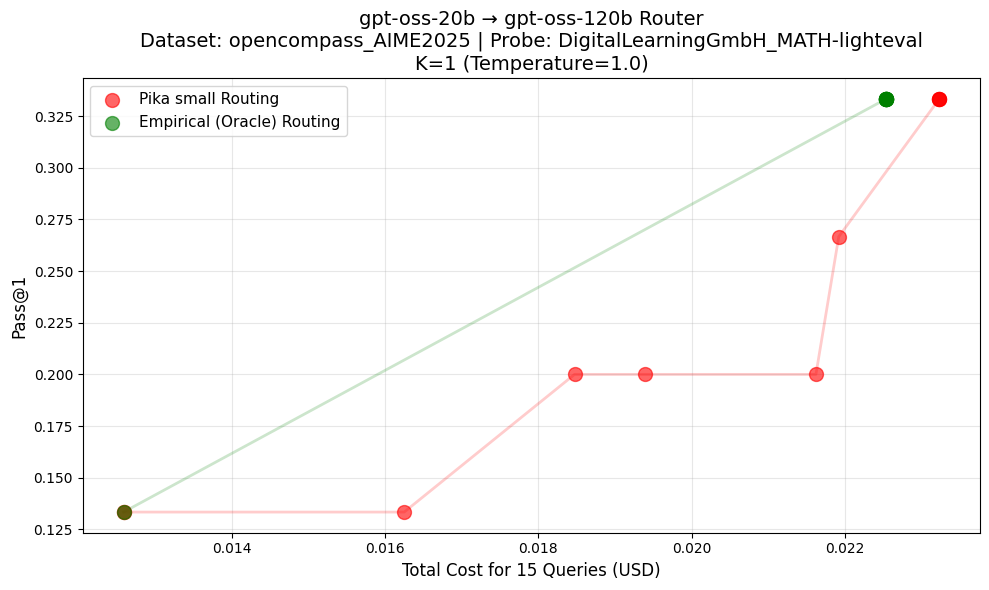


Routing Performance Across Thresholds (15 total queries):
Threshold    Probe Acc    Probe Total $   Empirical Acc Empirical Total $
----------------------------------------------------------------------
0.00         0.1333       $0.01           0.1333       $0.01          
0.10         0.1333       $0.01           0.3333       $0.02          
0.20         0.1333       $0.02           0.3333       $0.02          
0.30         0.2000       $0.02           0.3333       $0.02          
0.40         0.2000       $0.02           0.3333       $0.02          
0.50         0.2000       $0.02           0.3333       $0.02          
0.60         0.2667       $0.02           0.3333       $0.02          
0.70         0.3333       $0.02           0.3333       $0.02          
0.80         0.3333       $0.02           0.3333       $0.02          
0.90         0.3333       $0.02           0.3333       $0.02          
1.00         0.3333       $0.02           0.3333       $0.02          

SUMMARY:
Probe

In [161]:
# Plot: Accuracy vs Total Cost
plt.figure(figsize=(10, 6))
plt.scatter(probe_total_costs, probe_accs, color="red", s=100, alpha=0.6, label="Pika small Routing", zorder=3)
plt.scatter(empirical_total_costs, empirical_accs, color="green", s=100, alpha=0.6, label="Empirical (Oracle) Routing", zorder=3)

# Add connecting lines for visualization
plt.plot(probe_total_costs, probe_accs, color="red", alpha=0.2, linewidth=2)
plt.plot(empirical_total_costs, empirical_accs, color="green", alpha=0.2, linewidth=2)

plt.xlabel(f"Total Cost for {num_queries} Queries (USD)", fontsize=12)

# y_label = f"Pass@{K_SMALL}" if K_SMALL > 1 else f"Maj@{K_SMALL}"

if K_SMALL == 1:
    y_label = f"Pass@{K_SMALL}"

elif METRIC_COL == "success_rate" and K_SMALL > 1 :
    y_label = f"Pass@{K_SMALL}"
    
elif METRIC_COL == "majority_vote_is_correct" and K_SMALL > 1 :
    y_label = f"Maj@{K_SMALL}"


plt.ylabel(y_label, fontsize=12)

# Extract cleaner model names for title
small_model_name = MODEL_NAME_S.split('/')[-1]
large_model_name = MODEL_NAME_L.split('/')[-1]

plt.title(
    f"{small_model_name} → {large_model_name} Router\n"
    f"Dataset: {EVAL_DS} | Probe: {PROBING_DS_SOURCE}\n"
    f"K={K_SMALL} (Temperature={TEMP_SMALL})",
    fontsize=14
)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print results table with total costs
print(f"\nRouting Performance Across Thresholds ({num_queries} total queries):")
print(f"{'Threshold':<12} {'Probe Acc':<12} {'Probe Total $':<15} {'Empirical Acc':<12} {'Empirical Total $':<15}")
print("-" * 70)
for i, T in enumerate(THRESHOLDS):
    print(f"{T:<12.2f} {probe_accs[i]:<12.4f} ${probe_total_costs[i]:<14.2f} {empirical_accs[i]:<12.4f} ${empirical_total_costs[i]:<14.2f}")

# Summary statistics
print("\n" + "="*70)
print("SUMMARY:")
print(f"Probe-based routing total cost range: ${min(probe_total_costs):.4f} - ${max(probe_total_costs):.4f}")
print(f"Empirical (oracle) total cost range:  ${min(empirical_total_costs):.4f} - ${max(empirical_total_costs):.4f}")
print(f"Savings at best probe point (T={THRESHOLDS[probe_accs.index(max(probe_accs))]}): ${max(empirical_total_costs) - probe_total_costs[probe_accs.index(max(probe_accs))]:.4f}")

In [162]:
emperical_small_df["success_rate"].mean(), emperical_large_df["success_rate"].mean()

(0.13333333333333333, 0.3333333333333333)

In [163]:
emperical_small_df["majority_vote_is_correct"].mean(), emperical_large_df["majority_vote_is_correct"].mean()

(0.13333333333333333, 0.3333333333333333)

In [164]:
# ## Diagnose Missing Oracle Dots

# print("Total thresholds:", len(THRESHOLDS))
# print("Total empirical points:", len(empirical_accs))
# print("\nEmpirical accuracies and costs:")
# for i, T in enumerate(THRESHOLDS):
#     print(f"T={T:<4.2f}: Acc={empirical_accs[i]:.4f}, Cost={empirical_costs[i]:.6f}")

# # Check for duplicate (cost, accuracy) pairs
# empirical_pairs = list(zip(empirical_costs, empirical_accs))
# print(f"\nTotal unique empirical (cost, acc) pairs: {len(set(empirical_pairs))}")
# print(f"Total empirical points: {len(empirical_pairs)}")

# if len(set(empirical_pairs)) < len(empirical_pairs):
#     print("\nDuplicate pairs found:")
#     seen = {}
#     for i, pair in enumerate(empirical_pairs):
#         if pair in seen:
#             print(f"  T={THRESHOLDS[i]:.2f} matches T={THRESHOLDS[seen[pair]]:.2f}")
#         else:
#             seen[pair] = i